In [2]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

import os, os.path
import json 
import math 
import statistics
import utm
import numpy as np
import pandas as pd 
from pandas.io.json import json_normalize
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import cv2
import rasterio as rs
from rasterio.plot import show, show_hist
from rasterio.mask import mask
from rasterio.coords import BoundingBox
from rasterio import windows
from rasterio import warp
from rasterio.merge import merge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from scipy.stats import pearsonr

In [3]:
import sys
sys.path.append('../')
from src import utils 

## Vineyard input image and label distribution visulization 

In [3]:
img_dir   = '/data2/hkaman/Hyper'
label_dir = '/data2/hkaman/Livingston/LIV_tif/LIV2019/yield'

block_full_dict = utils.hyperspectral_label_mtx_gen(img_dir, label_dir, spatial_resolution = 14.5).block_image_label_gen()
df = utils.dataframe_split_csv_gen(block_full_dict, img_size = 8, offset = 2, cultivar_list = None).hyper_df_csv()
df

,block,X,Y,year,cultivar_id,cultivar,trellis,trellis_id,row,space,patch_mean
0,LIV_003_2019,0,34,2019,7,MALVASIA_BIANCA,4WIREWO,1,12,7,8.810658
1,LIV_003_2019,0,36,2019,7,MALVASIA_BIANCA,4WIREWO,1,12,7,8.818236
2,LIV_003_2019,0,38,2019,7,MALVASIA_BIANCA,4WIREWO,1,12,7,8.876853
3,LIV_003_2019,0,40,2019,7,MALVASIA_BIANCA,4WIREWO,1,12,7,8.922078
4,LIV_003_2019,0,42,2019,7,MALVASIA_BIANCA,4WIREWO,1,12,7,8.993444
...,...,...,...,...,...,...,...,...,...,...,...
8681,LIV_186_2019,28,38,2019,13,RIESLING,SPLIT,2,11,7,16.536495
8682,LIV_186_2019,28,40,2019,13,RIESLING,SPLIT,2,11,7,16.069435
8683,LIV_186_2019,28,42,2019,13,RIESLING,SPLIT,2,11,7,15.806927
8684,LIV_186_2019,28,44,2019,13,RIESLING,SPLIT,2,11,7,15.655951


In [4]:
block_name  = df.loc[0]['block'][:7]
block_name

'LIV_003'

In [6]:
full_image = block_full_dict['LIV_003_2019']['label']
full_image.shape

(1, 27, 108)

In [7]:
full_image

array([[[-1.       , -1.       , -1.       , ...,  8.735437 ,
          8.82352  ,  8.166645 ],
        [ 9.165484 ,  9.580114 ,  9.780308 , ...,  8.273588 ,
          8.62838  ,  8.196994 ],
        [ 8.953368 ,  8.966366 ,  9.229166 , ...,  7.0446973,
          8.085981 ,  7.584884 ],
        ...,
        [-1.       , -1.       , -1.       , ...,  8.619503 ,
          8.809552 ,  8.894365 ],
        [-1.       , -1.       , -1.       , ...,  9.433446 ,
          9.020381 ,  8.916123 ],
        [-1.       , -1.       , -1.       , ..., -1.       ,
         -1.       , -1.       ]]], dtype=float32)

In [7]:
train, valid, test = utils.dataframe_split_csv_gen(block_full_dict, img_size = 8, offset = 2, cultivar_list = None).split_data_()

In [8]:
train

,block,X,Y,year,cultivar_id,cultivar,trellis,trellis_id,row,space,patch_mean
0,LIV_003_2019,0,34,2019,7,MALVASIA_BIANCA,4WIREWO,1,12,7,8.810658
1,LIV_003_2019,0,36,2019,7,MALVASIA_BIANCA,4WIREWO,1,12,7,8.818236
2,LIV_003_2019,0,38,2019,7,MALVASIA_BIANCA,4WIREWO,1,12,7,8.876853
3,LIV_003_2019,0,40,2019,7,MALVASIA_BIANCA,4WIREWO,1,12,7,8.922078
4,LIV_003_2019,0,42,2019,7,MALVASIA_BIANCA,4WIREWO,1,12,7,8.993444
...,...,...,...,...,...,...,...,...,...,...,...
8355,LIV_178_2019,14,36,2019,13,RIESLING,SPLIT,2,11,5,20.288715
8356,LIV_178_2019,14,38,2019,13,RIESLING,SPLIT,2,11,5,20.079548
8357,LIV_178_2019,14,40,2019,13,RIESLING,SPLIT,2,11,5,19.603317
8358,LIV_178_2019,14,42,2019,13,RIESLING,SPLIT,2,11,5,19.012043


### By Cultivar

#### 'MALVASIA_BIANCA'

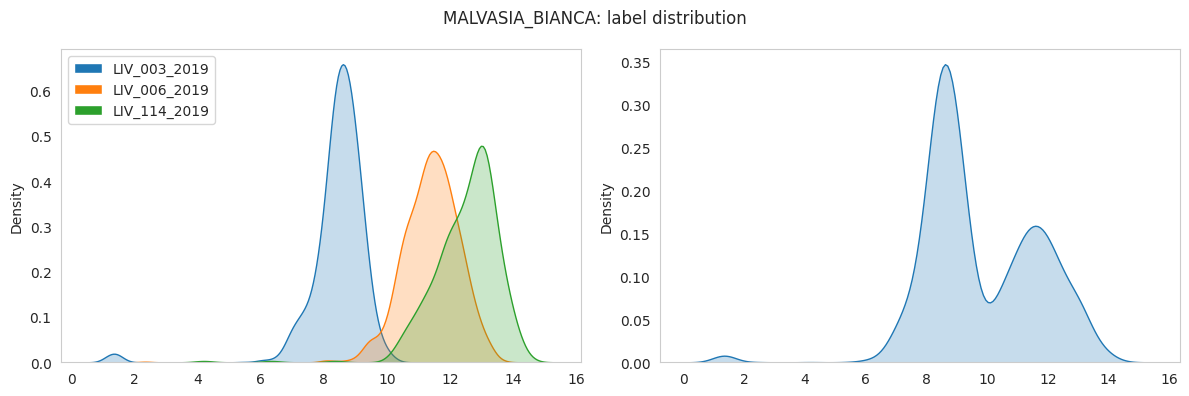

In [90]:
_ = utils.vineyard_data_visulization(block_full_dict, cultivar = ['MALVASIA_BIANCA']).by_cultivar_label_dist_vis()

#### 'MUSCAT_OF_ALEXANDRIA'

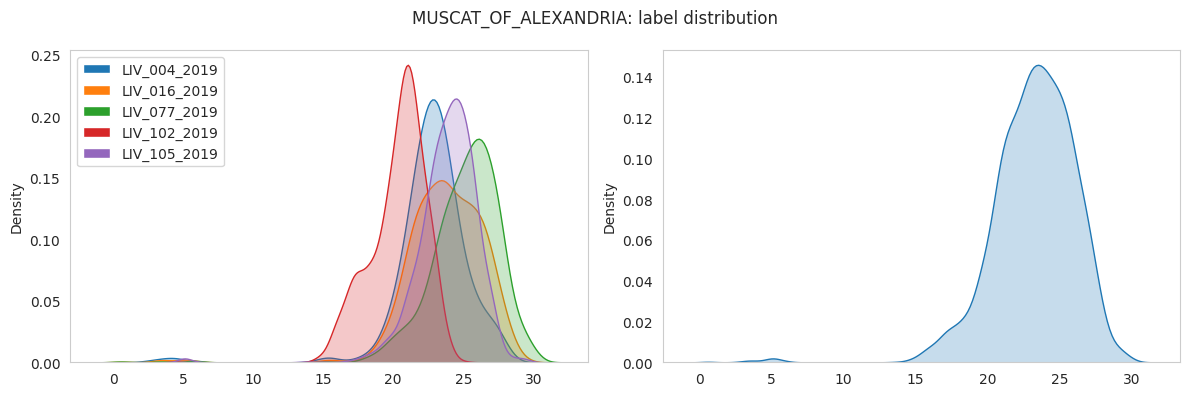

In [92]:
_ = utils.vineyard_data_visulization(block_full_dict, cultivar = ['MUSCAT_OF_ALEXANDRIA']).by_cultivar_label_dist_vis()

#### 'SYMPHONY'

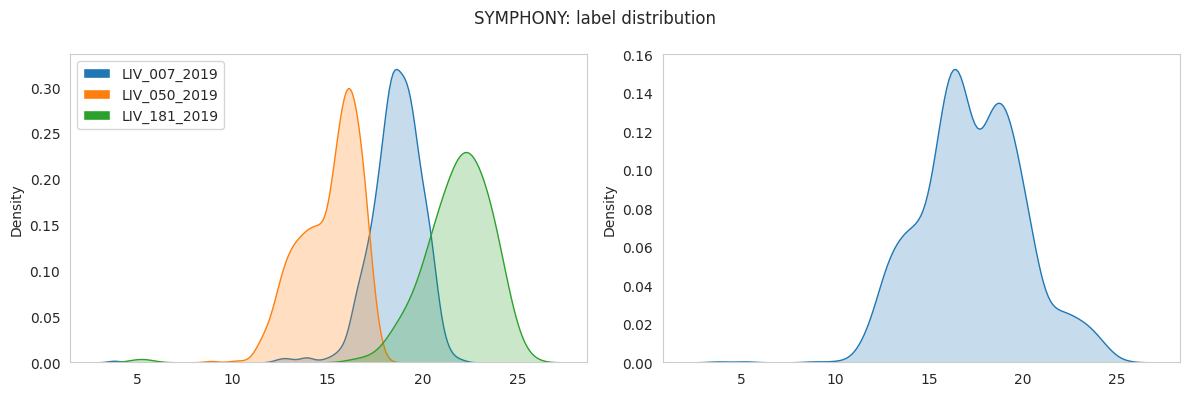

In [94]:
_ = utils.vineyard_data_visulization(block_full_dict, cultivar = ['SYMPHONY']).by_cultivar_label_dist_vis()

#### 'PINOT_GRIS'

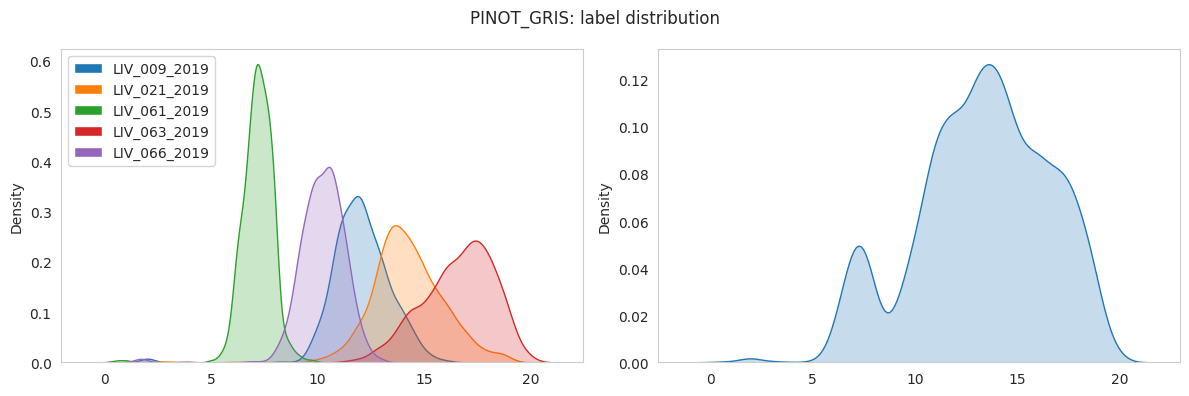

In [96]:
_ = utils.vineyard_data_visulization(block_full_dict, cultivar = ['PINOT_GRIS']).by_cultivar_label_dist_vis()

#### 'CHARDONNAY'

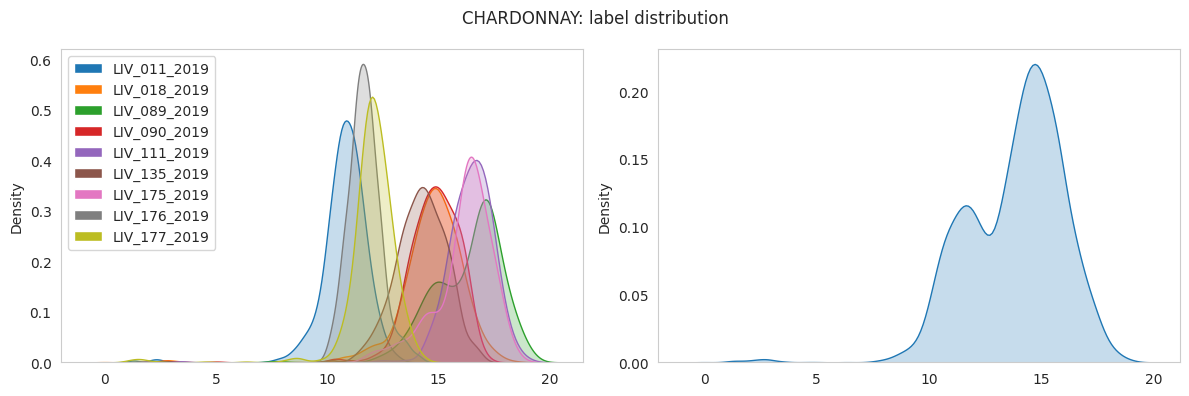

In [98]:
_ = utils.vineyard_data_visulization(block_full_dict, cultivar = ['CHARDONNAY']).by_cultivar_label_dist_vis()

#### 'SYRAH'

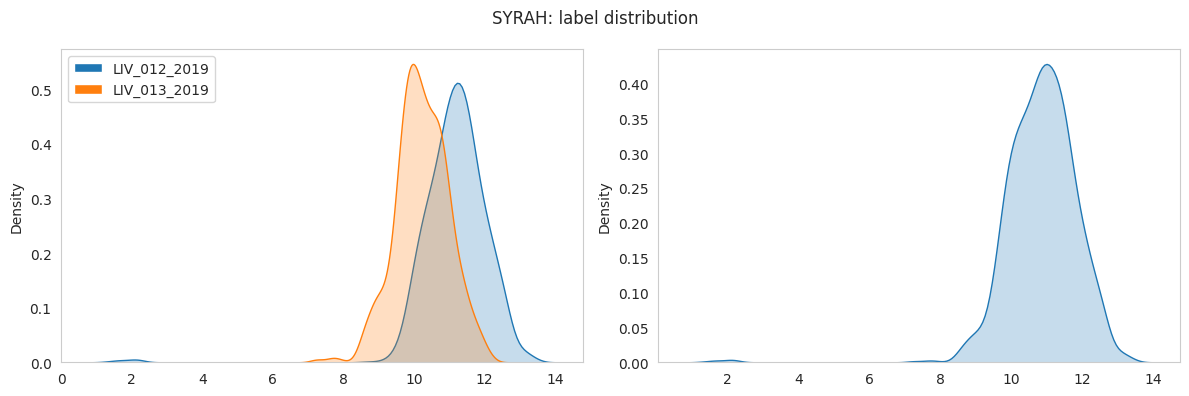

In [100]:
_ = utils.vineyard_data_visulization(block_full_dict, cultivar = ['SYRAH']).by_cultivar_label_dist_vis()

#### 'RIESLING'

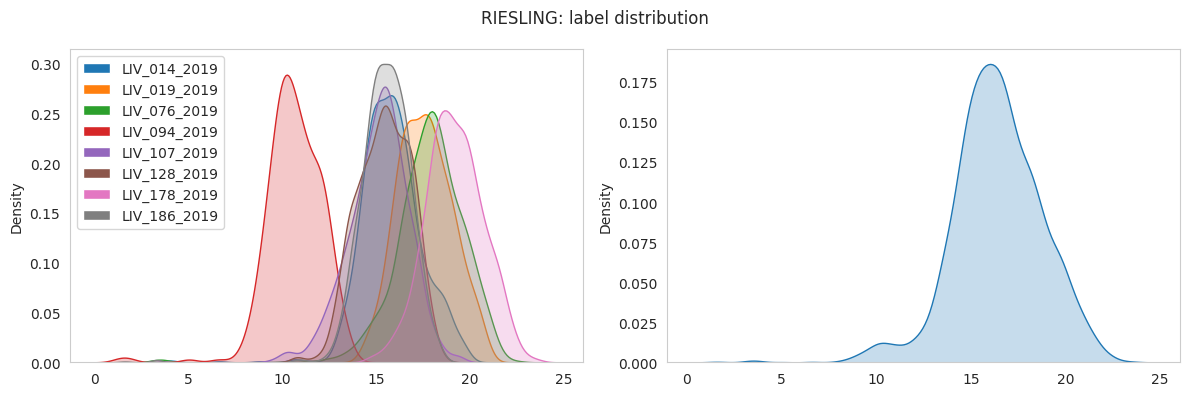

In [102]:
_ = utils.vineyard_data_visulization(block_full_dict, cultivar = ['RIESLING']).by_cultivar_label_dist_vis()

#### 'CABERNET_SAUVIGNON'

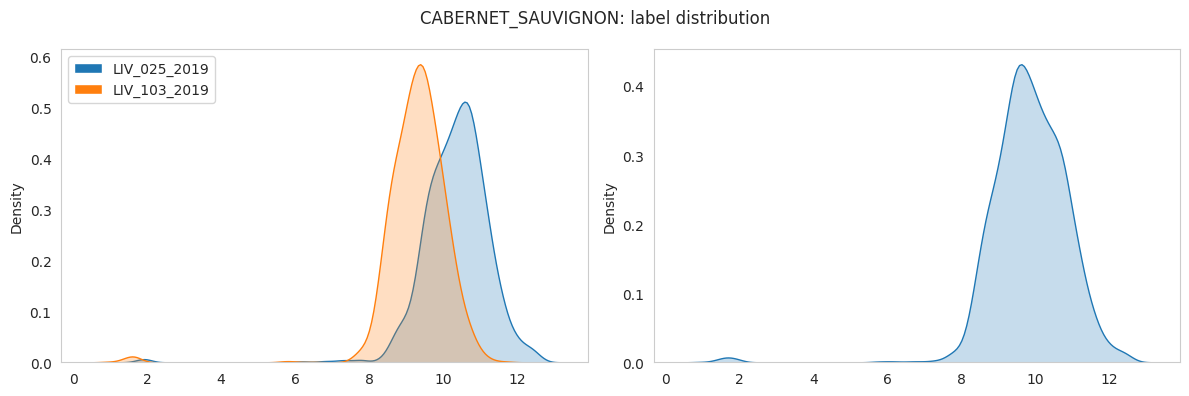

In [104]:
_ = utils.vineyard_data_visulization(block_full_dict, cultivar = ['CABERNET_SAUVIGNON']).by_cultivar_label_dist_vis()

### All Cultivar 

In [106]:
cultivars = ['MALVASIA_BIANCA', 'MUSCAT_OF_ALEXANDRIA', 'SYMPHONY',
       'PINOT_GRIS', 'CHARDONNAY', 'SYRAH', 'RIESLING',
       'CABERNET_SAUVIGNON']

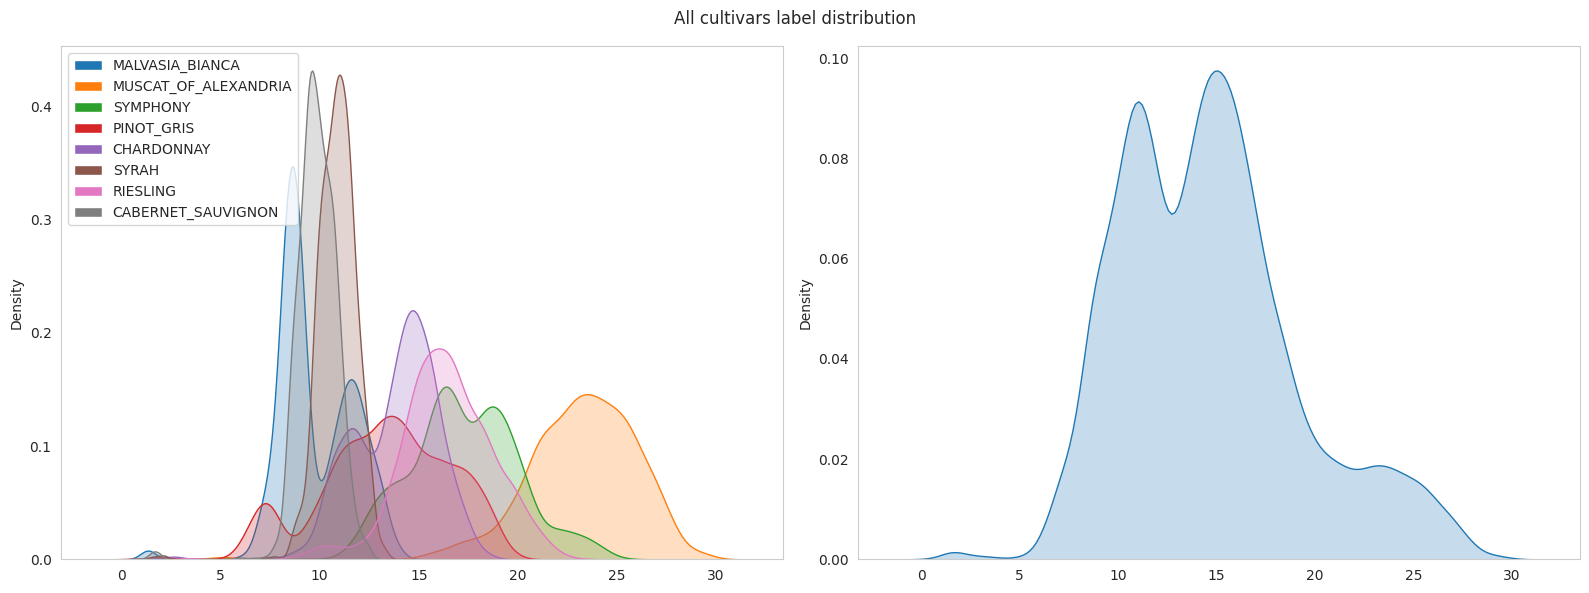

In [109]:
_ = utils.vineyard_data_visulization(block_full_dict, cultivar = cultivars).all_cultivar_label_dist_vis()

## Data ERRor Analysis 

In [3]:
S3_test_df_10m  = pd.read_csv('/data2/hkaman/Livingston/EXPs/10m/EXP_S3_UNetLSTM_10m_time/S3_UNetLSTM_10m_time_test.csv',  index_col=0) 
S3_test_df_10m

,ytrue,ypred_w1,ypred_w2,ypred_w3,ypred_w4,ypred_w5,ypred_w6,ypred_w7,ypred_w8,ypred_w9,ypred_w10,ypred_w11,ypred_w12,ypred_w13,ypred_w14,ypred_w15
0,9.271487,7.107851,7.383129,7.417369,7.406979,7.393731,7.387751,7.384769,7.388635,7.389146,7.389381,7.388850,7.388715,7.390129,7.389918,7.389486
1,9.144121,7.999155,8.239926,8.252578,8.241622,8.231303,8.226707,8.224359,8.227503,8.227856,8.228014,8.227500,8.227377,8.228559,8.228359,8.227984
2,8.767210,7.801857,7.903316,7.897556,7.873969,7.858596,7.851728,7.848433,7.852315,7.852593,7.852701,7.851802,7.851592,7.852908,7.852819,7.852449
3,8.643302,7.777064,7.900037,7.909532,7.894905,7.883028,7.877634,7.874662,7.878200,7.878458,7.878552,7.877823,7.877642,7.878921,7.878750,7.878400
4,8.755239,7.853014,7.861228,7.835494,7.799169,7.774845,7.763668,7.757763,7.763102,7.763355,7.763463,7.761839,7.761445,7.762126,7.763123,7.763465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3185403,16.347725,11.871423,12.188835,12.399028,12.566824,12.713540,12.820307,12.923777,12.987963,13.097857,13.226547,13.272000,13.227103,13.209606,13.131932,13.101980
3185404,16.153316,11.731035,12.136208,12.423729,12.637764,12.781852,12.871824,12.957881,13.015036,13.113121,13.221598,13.258040,13.220806,13.207103,13.137008,13.108747
3185405,15.845532,11.723237,12.169763,12.497248,12.732432,12.874880,12.958688,13.037337,13.091204,13.179878,13.272116,13.302020,13.270901,13.259372,13.197952,13.172347
3185406,16.285854,11.892816,12.415793,12.803701,13.059339,13.203503,13.282550,13.354656,13.402531,13.485483,13.572966,13.599884,13.567618,13.555257,13.493581,13.468044


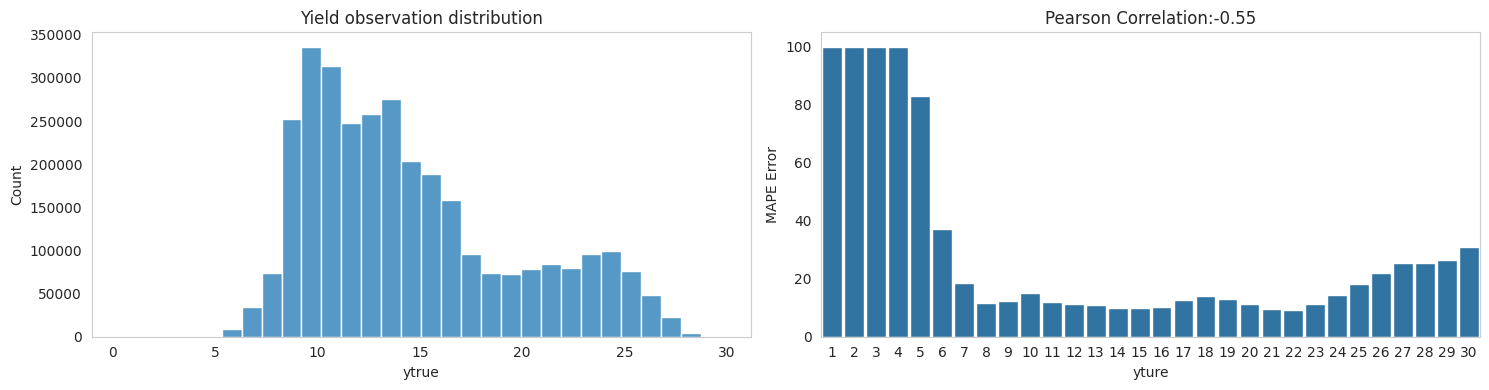

In [64]:
_ = utils.Erroe_hist_visulization(S3_test_df_10m)

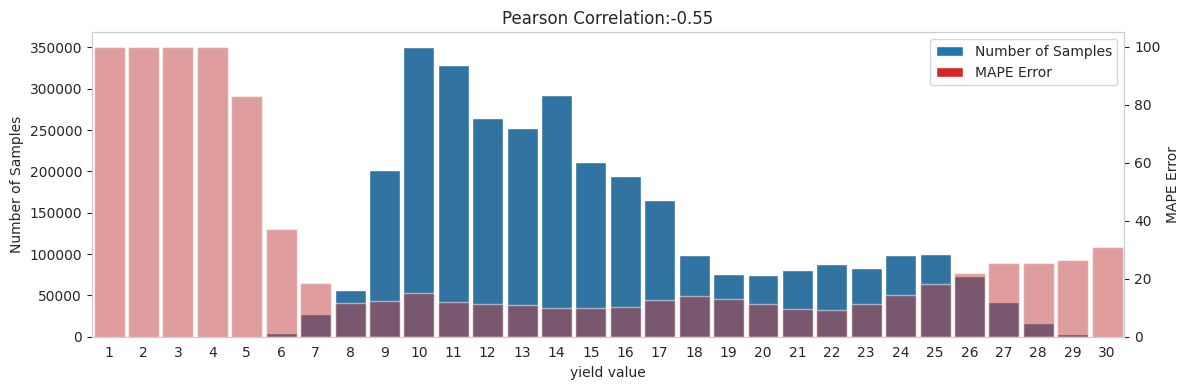

In [87]:
_ = utils.Erroe_hist_visulization_V2(S3_test_df_10m)

## Data Complexity Measures 

### Data Vis